In [53]:
import pandas as pd
import numpy as np

pd.set_option('display.max_columns', None) ## 모든 열을 출력한다.
# pd.set_option('display.max_rows', None)

import seaborn as sns
import matplotlib.pyplot as plt

import datetime
from dateutil.parser import parse
from tqdm import tqdm

import lightgbm as lgb
import bisect

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold

import warnings
warnings.filterwarnings('ignore')

# Unicode warning 제거 (폰트 관련 경고메시지)
plt.rcParams['axes.unicode_minus']=False

# 그래프 출력 사이즈 설정
plt.rcParams["figure.figsize"] = (10, 10)

sns.set(font="Hancom Gothic", 
        rc={"axes.unicode_minus":False}, # 마이너스 부호 깨짐 현상 해결
        style='darkgrid')

# 가. 데이터 불러오기

In [54]:
train = pd.read_csv('./Data/train(인코딩 후).csv')
test = pd.read_csv('./Data/test(인코딩 후).csv')

In [55]:
train.head(2)

,도착국가,도착 항구명,5대 선종으로 분류,정박지와 접안지 거리(km),선박식별 일련번호,선박 폭(m),선박 연령,선박 재화중량톤수(t),선박 깊이(m),흘수 높이(m),용적톤수 값,선박 길이(m),선박 소유주,선박 국적,풍향 u벡터(m/s),풍향 v벡터(m/s),기온(C),보퍼트 풍력 계급,현지 정박 시각(H),조정된 벌크운임지수,접안지 폴리곤 영역의 크기,대기시간(h),year,month,day,hour,minute,weekday,해당일 원유가격($)
0,4,13,0,30.736578,24336,30.0,28,73100,20.0,10.0,38600,220.0,591,18,0.14,3.77,15.9,2.730798,12,1407.668330,0.001660,3.048333,2020,10,15,4,3,3,42.00239
1,4,14,2,63.220425,19551,30.0,15,37900,20.0,10.0,28100,220.0,723,100,-3.16,-6.72,24.5,4.289058,10,2089.046774,0.001614,17.138611,2019,9,17,2,55,1,63.68114


In [56]:
test.head(2)

,도착국가,도착 항구명,5대 선종으로 분류,정박지와 접안지 거리(km),선박식별 일련번호,선박 폭(m),선박 연령,선박 재화중량톤수(t),선박 깊이(m),흘수 높이(m),용적톤수 값,선박 길이(m),선박 소유주,선박 국적,풍향 u벡터(m/s),풍향 v벡터(m/s),기온(C),보퍼트 풍력 계급,현지 정박 시각(H),해당일의 두바이유 값($),해당일의 브렌트유 값($),해당일의 WTI 값($),조정된 벌크운임지수,접안지 폴리곤 영역의 크기,year,month,day,hour,minute,weekday
0,9,26,4,9.508139,16892,20.0,9,5510,10.0,10.0,3720,100.0,5546,58,0.18,0.63,26.8,0.850060,17,97.88,96.49,89.55,766.977634,0.000256,2022,8,27,8,29,5
1,18,22,3,24.186684,5748,40.0,14,109000,20.0,10.0,94400,330.0,3357,93,-0.81,-0.77,27.5,1.213528,4,98.14,104.64,100.60,1655.006791,0.002615,2022,3,27,20,57,6


### 나. X, Y 분리

In [57]:
X = train.drop('대기시간(h)', axis=1)
y = train['대기시간(h)']

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3, 
                                                    random_state=42)

In [59]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((257123, 28), (257123,), (110196, 28), (110196,))

In [60]:
test.values

array([[ 9., 26.,  4., ...,  8., 29.,  5.],
       [18., 22.,  3., ..., 20., 57.,  6.],
       [20., 14.,  2., ...,  2.,  6.,  2.],
       ...,
       [ 5., 69.,  2., ..., 11., 26.,  3.],
       [24., 51.,  3., ...,  7., 20.,  2.],
       [24., 51.,  3., ..., 14.,  1.,  5.]])

# 다. 데이터 정규화/스케일링(Normalizing/Scaling)

In [61]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [62]:
X_train[:2], y_train[:2] #0~1사이로 숫자들이 바뀜 - 정규화

(array([[0.16666667, 0.19607843, 0.        , 0.07856031, 0.50678459,
         0.2       , 0.2625    , 0.04109928, 0.33333333, 0.5       ,
         0.04103863, 0.28947368, 0.88999846, 0.71311475, 0.43076923,
         0.48377004, 0.72556391, 0.31382917, 0.60869565, 0.4423459 ,
         0.01459258, 0.88888889, 0.36363636, 0.2       , 0.26086957,
         1.        , 0.83333333, 0.82436778],
        [0.83333333, 0.54901961, 0.        , 0.13910842, 0.71173572,
         0.4       , 0.2375    , 0.13072543, 0.66666667, 0.5       ,
         0.12349588, 0.44736842, 0.58810877, 0.59016393, 0.63269231,
         0.39968713, 0.42982456, 0.21512689, 0.30434783, 0.03839662,
         0.0429627 , 0.66666667, 0.09090909, 0.23333333, 0.17391304,
         0.27118644, 0.83333333, 0.34377228]]),
 311513     57.838056
 34935     409.153333
 Name: 대기시간(h), dtype: float64)

# 라. 모델 개발

#### 1. 모델별 바차트 그려주고 성능 확인을 위한 함수

In [167]:
# 모델별로 Accuracy 점수 저장
# 모델 Accuracy 점수 순서대로 바차트를 그려 모델별로 성능 확인 가능
#가져다가 쓰면됨
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error, r2_score

my_predictions_mse = {}
my_predictions_r2 = {}

colors = ['r', 'c', 'm', 'y', 'k', 'khaki', 'teal', 'orchid', 'sandybrown',
          'greenyellow', 'dodgerblue', 'deepskyblue', 'rosybrown', 'firebrick',
          'deeppink', 'crimson', 'salmon', 'darkred', 'olivedrab', 'olive', 
          'forestgreen', 'royalblue', 'indigo', 'navy', 'mediumpurple', 'chocolate',
          'gold', 'darkorange', 'seagreen', 'turquoise', 'steelblue', 'slategray', 
          'peru', 'midnightblue', 'slateblue', 'dimgray', 'cadetblue', 'tomato'
         ]

# 모델명, 예측값, 실제값을 주면 위의 plot_predictions 함수 호출하여 Scatter 그래프 그리며
# 모델별 MSE값을 Bar chart로 그려줌

# mean_squared_error(y_test,pred_y)**0.5
# r2_score(y_test,pred_y)
    
def regression_eval(name_, pred, actual):
    global predictions
    global colors

    plt.figure(figsize=(9, 12))

    mse = mean_squared_error(actual, pred)**0.5
    r2 = r2_score(actual, pred)
    
    my_predictions_mse[name_] = mse
    my_predictions_r2[name_] = r2

    y_mse_value = sorted(my_predictions_mse.items(), key=lambda x: x[1], reverse=True)
    y__r2_value = sorted(my_predictions_r2.items(), key=lambda x: x[1], reverse=True)
    
    df_mse = pd.DataFrame(y_mse_value, columns=['model', 'mse'])
    df_r2 = pd.DataFrame(y__r2_value, columns=['model', 'r2'])
    
    print(df_mse)
    print(df_r2)
   
    length = len(df_mse)
    length = len(df_r2)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (9,3), constrained_layout=True)
    
    # ----
    # ax = plt.subplot(1,2,1)
    ax1.set_yticks(np.arange(len(df_mse)))
    ax1.set_yticklabels(df_mse['model'], fontsize=15)
    bars = ax1.barh(np.arange(len(df_mse)), df_mse['mse'])
    
    for i, v in enumerate(df_mse['mse']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax1.text(v + 2, i, str(round(v, 3)), color='k', fontsize=11, fontweight='bold')
    
    ax1.set_title('Mean Squared Error')
    ax1.set_xlim(right = 200)
    
    # ----
    ax2 = plt.subplot(1,2,2)
    ax2.set_yticks(np.arange(len(df_r2)))
    ax2.set_yticklabels(df_r2['model'], fontsize=15)
    bars = ax2.barh(np.arange(len(df_r2)), df_r2['r2'])
     
    for i, v in enumerate(df_r2['r2']):
        idx = np.random.choice(len(colors))
        bars[i].set_color(colors[idx])
        ax2.text(v + 0.01, i, str(round(v, 3)), color='k', fontsize=11, fontweight='bold')
    
    ax2.set_title('R2')
    ax2.set_xlim(right = 1)
    
    # plt.title('mse', fontsize=18)
    
    plt.show()

###  
### 1) 다중선형회귀 (LinearRegression)

In [168]:
from sklearn.linear_model import LinearRegression as lr
from sklearn.metrics import roc_auc_score, accuracy_score, mean_squared_error, r2_score

In [169]:
model = lr()
model.fit(X_train, y_train)

print("모델의 회귀계수는 : ", model.coef_, "\n모델의 절편은 : ",model.intercept_, '\n')

y_pred = model.predict(X_test)
print("RMSE on Test set : {0:.5f}".format(mean_squared_error(y_test, y_pred)**0.5))
print("R-squared Score on Test set : {0:.5f}".format(r2_score(y_test, y_pred)))

모델의 회귀계수는 :  [ 5.18121823e+01  1.75371021e+00 -6.20578801e+01  2.20645858e+02
 -3.94233023e+00 -4.52129701e+01  6.68509178e+01  5.08216399e+01
  3.23530002e+01 -3.13509199e+01  1.61136364e+02 -8.23860978e+01
 -5.27370458e-01  1.28775175e+01 -1.53148310e+01  1.37926284e-01
  4.12517299e+01 -2.20254347e+01  2.42088426e+00 -8.90195197e+00
  1.46834532e+01  4.40493501e+00  2.01177049e+00 -1.54207465e+00
  6.05290846e+00  3.70038292e+00  4.87412159e+01  3.27264515e+01] 
모델의 절편은 :  -8.171653726627667 

RMSE on Test set : 164.71071
R-squared Score on Test set : 0.06682


              model         mse
0  LinearRegression  164.710707
              model       r2
0  LinearRegression  0.06682


<Figure size 900x1200 with 0 Axes>

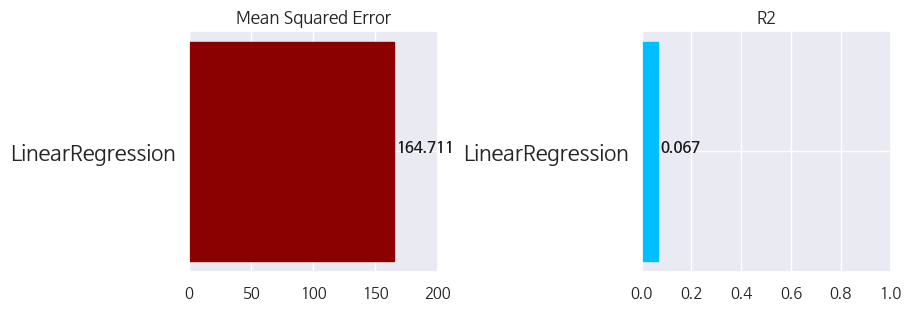

In [170]:
regression_eval('LinearRegression', y_pred, y_test)

###   
### 2) KNN (K-Nearest Neighbor)

In [171]:
from sklearn.neighbors import KNeighborsRegressor

In [172]:
knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train, y_train)

KNeighborsRegressor()

In [173]:
knn_pred = knn.predict(X_test)

                model         mse
0  K-Nearest Neighbor  167.942944
1    LinearRegression  164.710707
                model        r2
0    LinearRegression  0.066820
1  K-Nearest Neighbor  0.029836


<Figure size 900x1200 with 0 Axes>

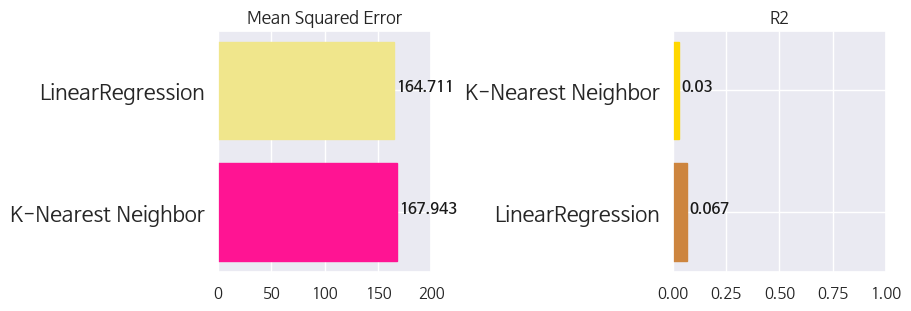

In [174]:
regression_eval('K-Nearest Neighbor', knn_pred, y_test) #성능비교

###  
### 3) 결정트리(DecisionTree)

In [175]:
from sklearn.tree import DecisionTreeRegressor

In [176]:
dt = DecisionTreeRegressor(max_depth=15, random_state=42)
dt.fit(X_train, y_train)


DecisionTreeRegressor(max_depth=15, random_state=42)

In [177]:
dt_pred = dt.predict(X_test)

                model         mse
0  K-Nearest Neighbor  167.942944
1    LinearRegression  164.710707
2        DecisionTree  164.155895
                model        r2
0        DecisionTree  0.073096
1    LinearRegression  0.066820
2  K-Nearest Neighbor  0.029836


<Figure size 900x1200 with 0 Axes>

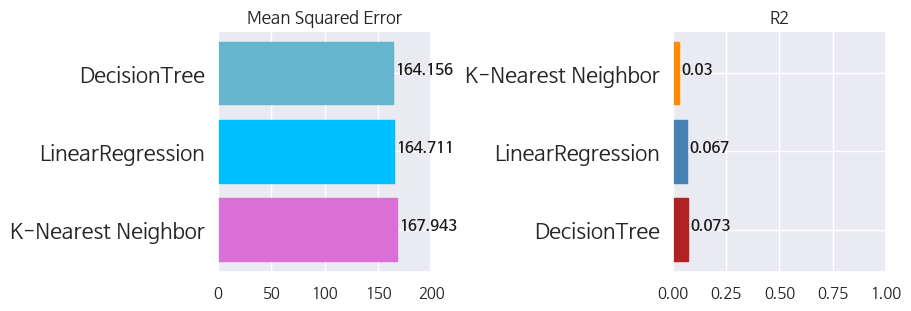

In [178]:
regression_eval('DecisionTree', dt_pred, y_test)
#바 차트 그리기

### 
### **앙상블 기법의 종류**
- 배깅 (Bagging): 여러개의 DecisionTree 활용하고 샘플 중복 생성을 통해 결과 도출. RandomForest
- 부스팅 (Boosting): 약한 학습기를 순차적으로 학습을 하되, 이전 학습에 대하여 잘못 예측된 데이터에 가중치를 부여해 오차를 보완해 나가는 방식. XGBoost, LGBM
- 스태킹 (Stacking): 여러 모델을 기반으로 예측된 결과를 통해 Final 학습기(meta 모델)이 다시 한번 예측

![앙상블](https://teddylee777.github.io/images/2019-12-18/image-20191217144823555.png)

###  
### 4) 랜덤포레스트(RandomForest)
+ Bagging 대표적인 모델로써, 훈련셋트를 무작위로 각기 다른 서브셋으로 데이터셋을 만들고
+ 여러개의 DecisonTree로 학습하고 다수결로 결정하는 모델

**주요 Hyperparameter**
- random_state: 랜덤 시드 고정 값. 고정해두고 튜닝할 것!
- n_jobs: CPU 사용 갯수
- max_depth: 깊어질 수 있는 최대 깊이. 과대적합 방지용
- n_estimators: 앙상블하는 트리의 갯수
- max_features: 최대로 사용할 feature의 갯수. 과대적합 방지용
- min_samples_split: 트리가 분할할 때 최소 샘플의 갯수. default=2. 과대적합 방지용

In [179]:
from sklearn.ensemble import RandomForestRegressor

In [180]:
rfc = RandomForestRegressor(n_estimators=10, random_state=42) #decision tree 3개 사용
rfc.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=42)

In [181]:
rfc_pred = rfc.predict(X_test)

                   model         mse
0     K-Nearest Neighbor  167.942944
1       LinearRegression  164.710707
2           DecisionTree  164.155895
3  RandomForest Ensemble  149.870547
                   model        r2
0  RandomForest Ensemble  0.227401
1           DecisionTree  0.073096
2       LinearRegression  0.066820
3     K-Nearest Neighbor  0.029836


<Figure size 900x1200 with 0 Axes>

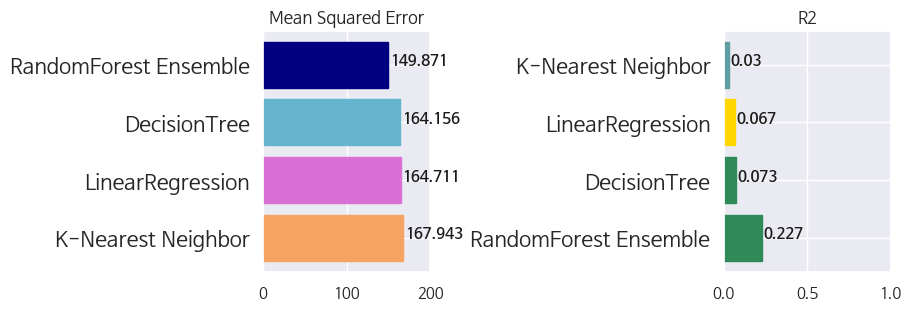

In [182]:
regression_eval('RandomForest Ensemble', rfc_pred, y_test)

###  
### 5) XGBoost
+ 여러개의 DecisionTree를 결합하여 Strong Learner 만드는 Boosting 앙상블 기법
+ Kaggle 대회에서 자주 사용하는 모델이다.

**주요 특징**
- scikit-learn 패키지가 아닙니다.
- 성능이 우수함
- GBM보다는 빠르고 성능도 향상되었습니다.
- 여전히 학습시간이 매우 느리다

**주요 Hyperparameter**
- random_state: 랜덤 시드 고정 값. 고정해두고 튜닝할 것!
- n_jobs: CPU 사용 갯수
- learning_rate: 학습율. 너무 큰 학습율은 성능을 떨어뜨리고, 너무 작은 학습율은 학습이 느리다. 적절한 값을 찾아야함. n_estimators와 같이 튜닝. default=0.1
- n_estimators: 부스팅 스테이지 수. (랜덤포레스트 트리의 갯수 설정과 비슷한 개념). default=100
- max_depth: 트리의 깊이. 과대적합 방지용. default=3. 
- subsample: 샘플 사용 비율. 과대적합 방지용. default=1.0
- max_features: 최대로 사용할 feature의 비율. 과대적합 방지용. default=1.0

In [183]:
# !pip install xgboost

In [184]:
from xgboost import XGBRegressor

In [185]:
xgb = XGBRegressor(n_estimators=5, random_state=42)  # 10초 소요
xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=5, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

In [186]:
xgb_pred = xgb.predict(X_test)

                   model         mse
0     K-Nearest Neighbor  167.942944
1       LinearRegression  164.710707
2           DecisionTree  164.155895
3                XGBoost  151.436637
4  RandomForest Ensemble  149.870547
                   model        r2
0  RandomForest Ensemble  0.227401
1                XGBoost  0.211170
2           DecisionTree  0.073096
3       LinearRegression  0.066820
4     K-Nearest Neighbor  0.029836


<Figure size 900x1200 with 0 Axes>

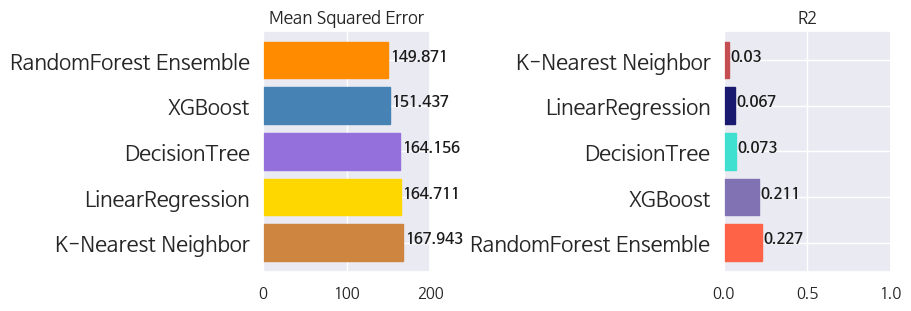

In [187]:
regression_eval('XGBoost', xgb_pred, y_test)

###  
### 6) Light GBM
+ XGBoost와 함께 주목받는 DecisionTree 알고리즘 기반의 Boosting 앙상블 기법
+ XGBoost에 비해 학습시간이 짧은 편이다.

**주요 특징**
- scikit-learn 패키지가 아닙니다.
- 성능이 우수함
- 속도도 매우 빠릅니다.

**주요 Hyperparameter**
- random_state: 랜덤 시드 고정 값. 고정해두고 튜닝할 것!
- n_jobs: CPU 사용 갯수
- learning_rate: 학습율. 너무 큰 학습율은 성능을 떨어뜨리고, 너무 작은 학습율은 학습이 느리다. 적절한 값을 찾아야함. n_estimators와 같이 튜닝. default=0.1
- n_estimators: 부스팅 스테이지 수. (랜덤포레스트 트리의 갯수 설정과 비슷한 개념). default=100
- max_depth: 트리의 깊이. 과대적합 방지용. default=3. 
- colsample_bytree: 샘플 사용 비율 (max_features와 비슷한 개념). 과대적합 방지용. default=1.0

In [188]:
# !pip install lightgbm #싸이킬런 아니라 별도로 섪치

In [189]:
from lightgbm import LGBMRegressor

In [190]:
lgbm = LGBMRegressor(n_estimators=5, random_state=42)   # 1분 소요 ->파라미터 수 늘리면 성능이 오를 수 있다
lgbm.fit(X_train, y_train)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007878 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3416
[LightGBM] [Info] Number of data points in the train set: 257123, number of used features: 28
[LightGBM] [Info] Start training from score 62.001637


LGBMRegressor(n_estimators=5, random_state=42)

In [191]:
lgbm_pred = lgbm.predict(X_test)

                   model         mse
0     K-Nearest Neighbor  167.942944
1       LinearRegression  164.710707
2           DecisionTree  164.155895
3                   LGBM  158.356204
4                XGBoost  151.436637
5  RandomForest Ensemble  149.870547
                   model        r2
0  RandomForest Ensemble  0.227401
1                XGBoost  0.211170
2                   LGBM  0.137435
3           DecisionTree  0.073096
4       LinearRegression  0.066820
5     K-Nearest Neighbor  0.029836


<Figure size 900x1200 with 0 Axes>

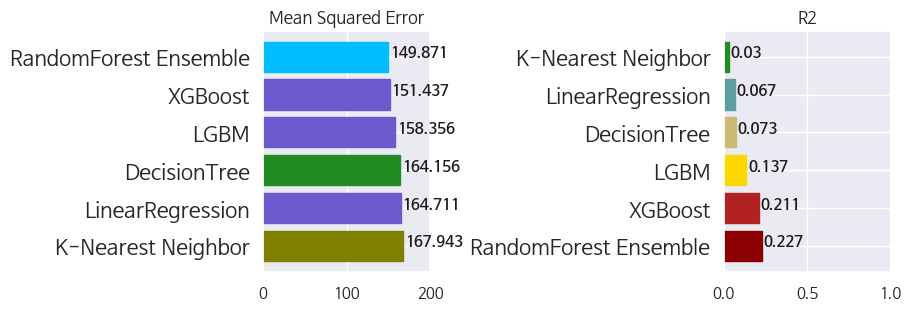

In [192]:
regression_eval('LGBM', lgbm_pred, y_test)

In [193]:
dsf

NameError: name 'dsf' is not defined

### 7) Stacking

개별 모델이 예측한 데이터를 기반으로 **final_estimator** 종합하여 예측을 수행합니다.
- 성능을 극으로 끌어올릴 때 활용하기도 합니다.
- 과대적합을 유발할 수 있습니다. (특히, 데이터셋이 적은 경우)

In [ ]:
from sklearn.ensemble import StackingRegressor, StackingClassifier

In [ ]:
stack_models = [
    ('LogisticRegression', lg), 
    ('KNN', knn), 
    ('DecisionTree', dt),
]

In [ ]:
# stack_models로 선언된 모델(LogisticRegression,KNN,DecisionTree)의 예측결과를 최종 meta_model(final_estimator)을 RandomForest(rfc) 사용하여 분류 예측 
stacking = StackingClassifier(stack_models, final_estimator=rfc, n_jobs=-1)

In [ ]:
stacking.fit(X_train, y_train)   # 1분 20초 소요

StackingClassifier(estimators=[('LogisticRegression',
                                LogisticRegression(max_iter=2000)),
                               ('KNN', KNeighborsClassifier()),
                               ('DecisionTree',
                                DecisionTreeClassifier(max_depth=10,
                                                       random_state=42))],
                   final_estimator=RandomForestClassifier(n_estimators=3,
                                                          random_state=42),
                   n_jobs=-1)

In [ ]:
stacking_pred = stacking.predict(X_test)

                   model   accuracy
0                XGBoost  97.825160
1  RandomForest Ensemble  97.611940
2           DecisionTree  97.313433
3      Stacking Ensemble  96.247335
4     K-Nearest Neighbor  94.712154
5     LogisticRegression  92.963753
6                   LGBM  89.936034


<Figure size 864x648 with 0 Axes>

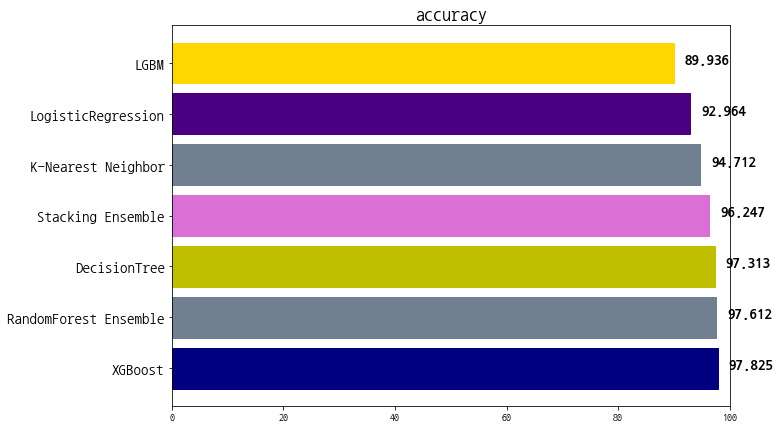

In [ ]:
accuracy_eval('Stacking Ensemble', stacking_pred, y_test)

### 8) Weighted Blending

각 모델의 예측값에 대하여 weight를 곱하여 최종 output 계산
- 모델에 대한 가중치를 조절하여, 최종 output을 산출합니다.
- **가중치의 합은 1.0**이 되도록 합니다.

In [ ]:
final_outputs = {
    'DecisionTree': dt_pred, 
    'randomforest': rfc_pred, 
    'xgb': xgb_pred, 
    'lgbm': lgbm_pred,
    'stacking': stacking_pred,
} #각각의 예측값

In [ ]:
final_prediction=\
final_outputs['DecisionTree'] * 0.1\
+final_outputs['randomforest'] * 0.2\
+final_outputs['xgb'] * 0.25\
+final_outputs['lgbm'] * 0.15\
+final_outputs['stacking'] * 0.3\
#각각 가중치를 곱한다.

In [ ]:
# 가중치 계산값이 0.5 초과하면 1, 그렇지 않으면 0
final_prediction = np.where(final_prediction > 0.5, 1, 0)

                   model   accuracy
0                XGBoost  97.825160
1      Weighted Blending  97.697228
2  RandomForest Ensemble  97.611940
3           DecisionTree  97.313433
4      Stacking Ensemble  96.247335
5     K-Nearest Neighbor  94.712154
6     LogisticRegression  92.963753
7                   LGBM  89.936034


<Figure size 864x648 with 0 Axes>

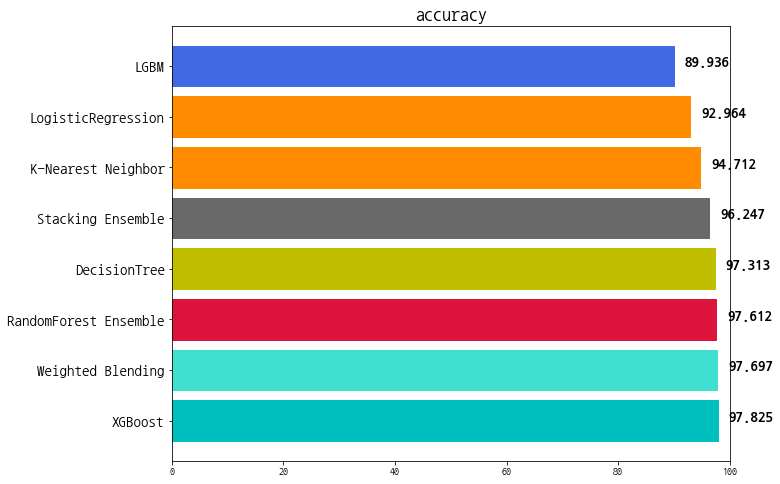

In [ ]:
accuracy_eval('Weighted Blending', final_prediction, y_test)